<a href="https://colab.research.google.com/github/mbfons/colab-workbooks/blob/master/NHSApp_forecasting_prescriptions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#allows you to access google drive files from the notebook
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load libraries of interest
#!pip install statsmodels.tsa
#!pip install statsmodels --upgrade # to upgrade statsmodels to latest version (0.13.0), otherwise the ARIMA import may throw an error
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import dates
from matplotlib import pyplot
import statsmodels.api as sm
import statsmodels
import statsmodels.tsa
from datetime import datetime, timedelta
from pandas.plotting import autocorrelation_plot
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
import math
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

In [ ]:
#read from csv (so don't have to read 2gb file every time)
location = "/content/drive/Shareddrives/NHSX Analytics Unit/Programme Analytics Branch/Analytics Team/EtP   Mission 2/M2 modelling/python analysis/app_uptake.csv"
df_gp = pd.read_csv(location)

In [ ]:
#convert report_date field from string to datetime
df_gp['Report_Date'] = pd.to_datetime(df_gp['Report_Date'])
df_gp =df_gp.set_index('Report_Date');

In [ ]:
# resample to weekly and slice
t_min = '2019-01-01'
t_max='2021-09-01'

aux_m = df_gp[['NHSApp_RegistrationsCount','Usage_LoginSessions_Login_Sessions','Usage_Appointments_Appointments_booked','Usage_CancelledAppointments_Cancellation_Count','Usage_Prescriptions_Prescriptions_Ordered','Usage_MedicalRecords_Medical_record_views']].resample('m').sum()
aux_m=aux_m[t_min:t_max]

In [ ]:
data_presc = data_n = aux_m['Usage_Prescriptions_Prescriptions_Ordered']

# Usage of Prescriptions
- What does the time series look like? Any noteworthy trend or seasonality?
- Is it stationary?
- How correlated are the terms?
- What may be the best model (from within ARIMA family)
- What does a prediction look like if it's just trying to predit: only one timepoint ahead each time; several points ahead from a given timepoint

## Decomposition

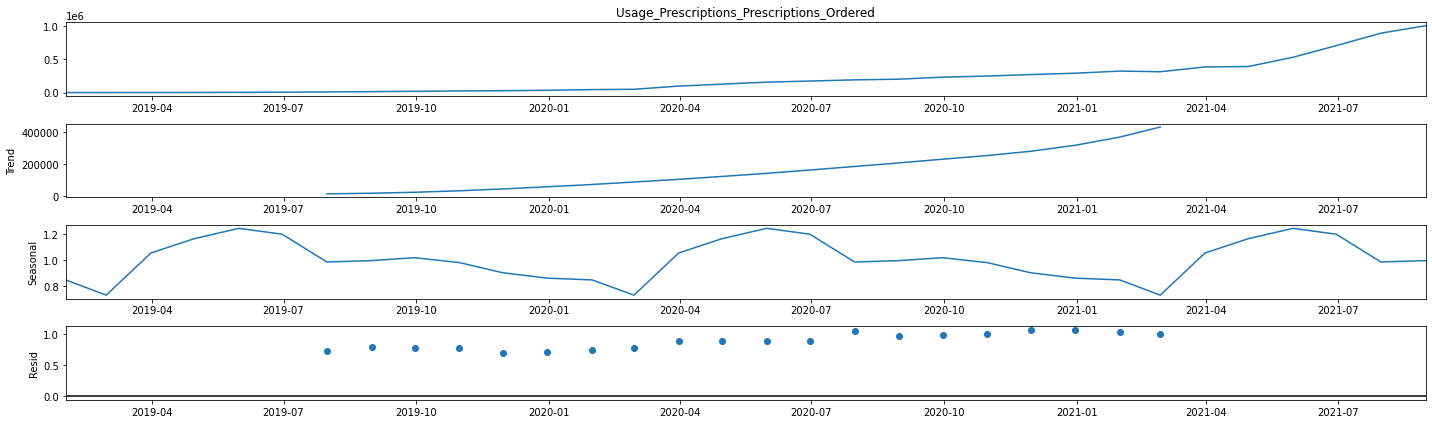

In [ ]:
decomposition = sm.tsa.seasonal_decompose(data_presc,model='multiplicative')
plt.rcParams["figure.figsize"] = (20,6)
ax = decomposition.plot()
ax.show()

## Stationarity considerations

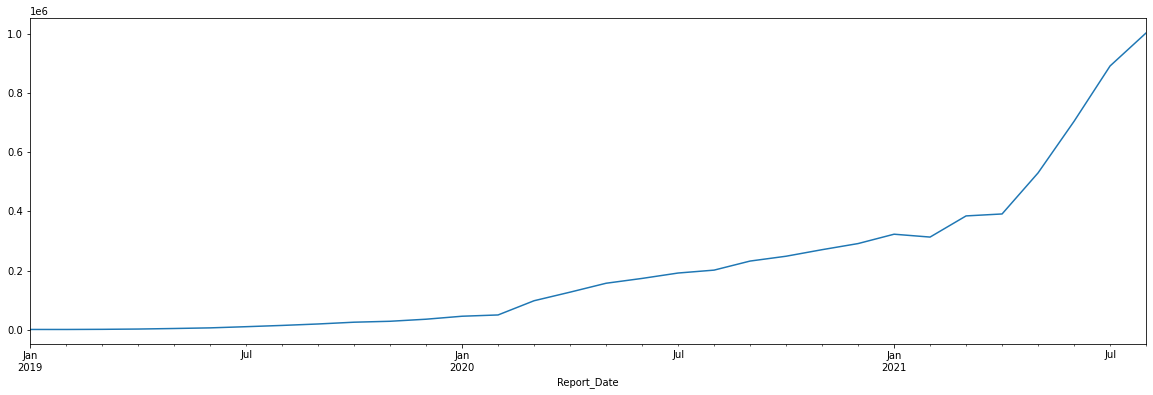

In [ ]:
# Plot prescriptions
data_presc.plot()

Plotting the prescriptions data. Clearly there is a trend. Data is not stationary, and will require differencing by at least an order of one

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [ ]:
adf_test(data_presc)

Augmented Dickey-Fuller Test: 
ADF test statistic       2.392368
p-value                  0.999007
# lags used              7.000000
# observations          24.000000
critical value (1%)     -3.737709
critical value (5%)     -2.992216
critical value (10%)    -2.635747
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [ ]:
from statsmodels.tsa.statespace.tools import diff
adf_test(diff(data_presc,k_diff=1))

Augmented Dickey-Fuller Test: 
ADF test statistic      -1.616078
p-value                  0.474786
# lags used              2.000000
# observations          28.000000
critical value (1%)     -3.688926
critical value (5%)     -2.971989
critical value (10%)    -2.625296
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [ ]:
adf_test(diff(data_presc,k_diff=2))

Augmented Dickey-Fuller Test: 
ADF test statistic      -3.521315
p-value                  0.007456
# lags used              4.000000
# observations          25.000000
critical value (1%)     -3.723863
critical value (5%)     -2.986489
critical value (10%)    -2.632800
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


The tests above indicate two levels of differencing needed to achieve stationarity.

## Auto-correlation considerations

Auto-correlation for a large number of lags in time. Up to 3-4 lags would be reasonable as a starting point

In [ ]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for help in determining (p,q) orders (AR , MA)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


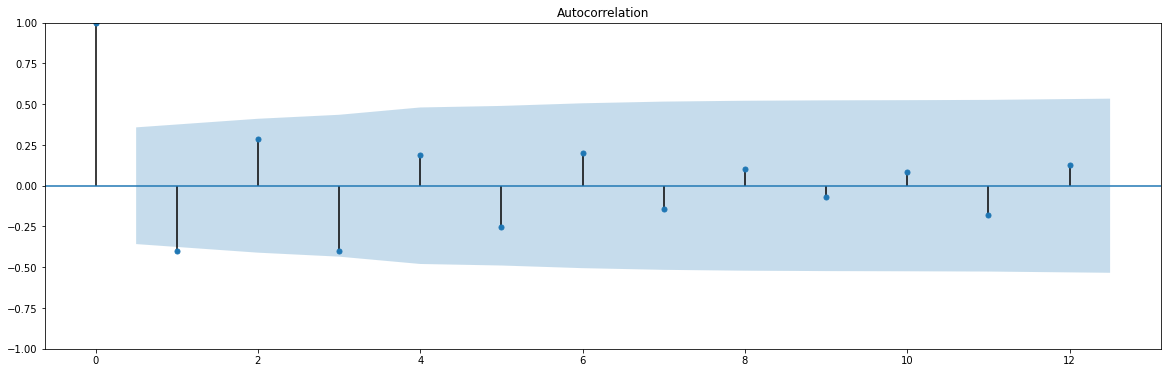

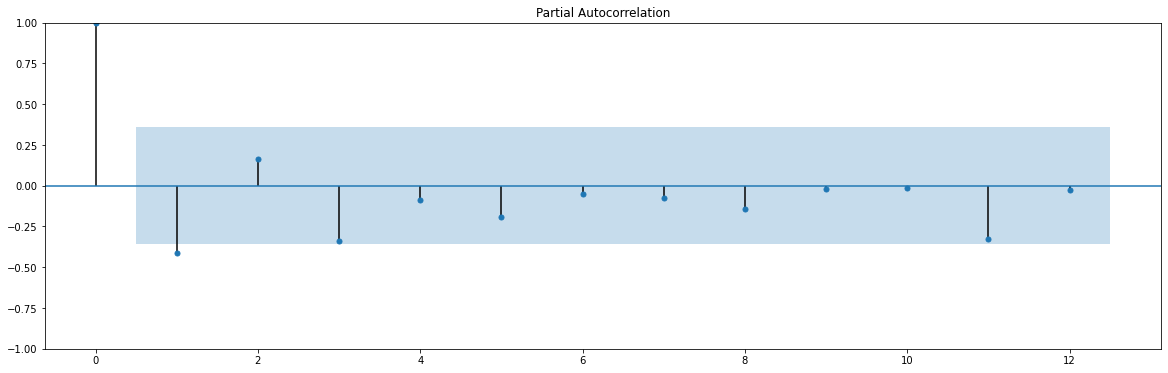

In [ ]:
## Alternative method for ACF plot
#autocorrelation_plot(diff(data_n,2))
#pyplot.show()

# ACF plot
plot_acf(diff(data_n,2),lags=12);

# PACF plot
plot_pacf(diff(data_n,2),lags=12);

## Auto-regression (ARIMA(p,0,0))

In [ ]:
import statsmodels
import statsmodels.tsa
from statsmodels.tsa.ar_model import AutoReg

In [ ]:
# fit Auto-regression model
model_AR = AutoReg(data_n,lags=3)
model_AR_fit = model_AR.fit()

In [ ]:
# summary of fit model
print(model_AR_fit.summary())

                                        AutoReg Model Results                                        
Dep. Variable:     Usage_Prescriptions_Prescriptions_Ordered   No. Observations:                   32
Model:                                            AutoReg(3)   Log Likelihood                -341.753
Method:                                      Conditional MLE   S.D. of innovations          31750.171
Date:                                       Mon, 08 Nov 2021   AIC                            693.506
Time:                                               11:36:16   BIC                            700.343
Sample:                                           04-30-2019   HQIC                           695.647
                                                - 08-31-2021                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

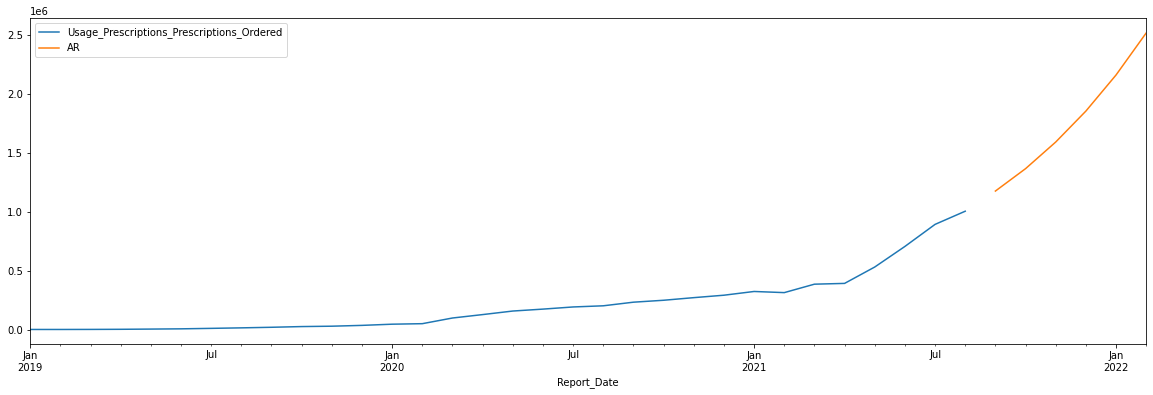

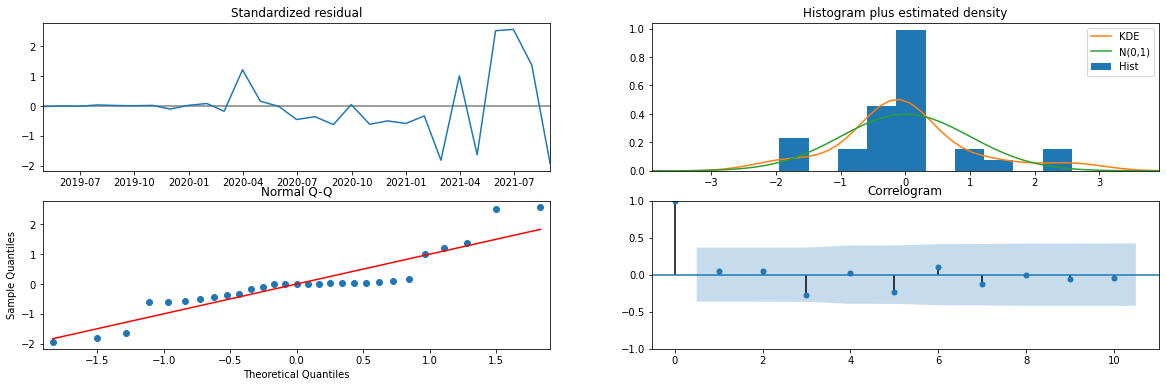

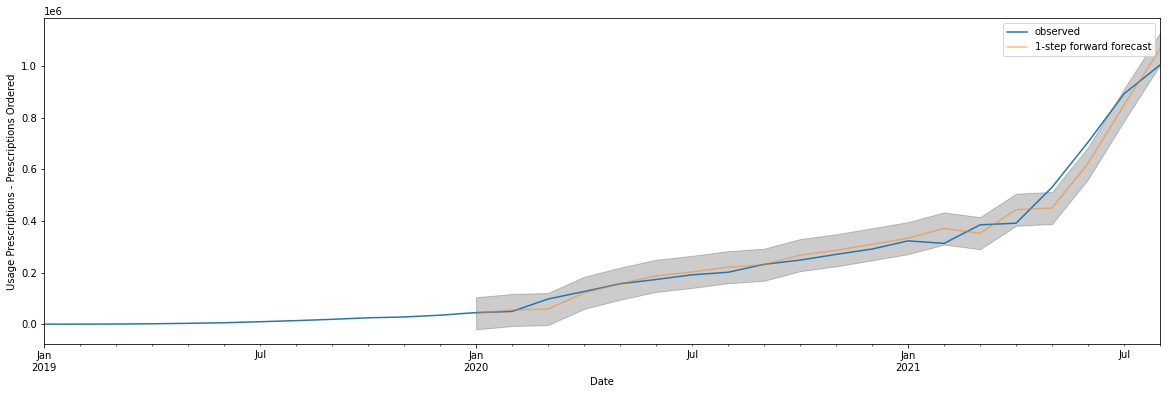

The MSE is 1461033702.86
The RMSE is 38223.47


In [ ]:
# Predictions
y_hat = model_AR_fit.predict(len(data_n),len(data_n)+5,dynamic=True)
y_hat = pd.Series(y_hat,name='AR')
#print(y_hat)
#model_AR_fit.predict();

pd.concat([data_presc,y_hat],axis=1).plot()

plot_res_expl=False
if plot_res_expl:
  # line plot of residuals
  residuals = pd.DataFrame(model_AR_fit.resid)
  residuals.plot()
  pyplot.show()
  # density plot of residuals
  residuals.plot(kind='kde')
  pyplot.show()
  # summary stats of residuals
  print(residuals.describe())

# plotting diagnostics
model_AR_fit.plot_diagnostics()
plt.show()

# plotting prediction - appr 2
y_hat2 = model_AR_fit.get_prediction(start=pd.to_datetime('2020-01-31'),dynamic=False)
y_hat2_ci = y_hat2.conf_int()

ax = data_presc.plot(label='observed')
y_hat2.predicted_mean.plot(ax=ax,label='1-step forward forecast',alpha=0.5)
ax.fill_between(y_hat2_ci.index,
                y_hat2_ci.iloc[:,0],
                y_hat2_ci.iloc[:,1],
                color='k',
                alpha=0.2)
ax.set_xlabel('Date')
ax.set_ylabel('Usage Prescriptions - Prescriptions Ordered')
plt.legend()
plt.show()

y_true = data_presc['2020-01-31':]
mse = ((y_hat2.predicted_mean - y_true)**2).mean()
rmse = np.sqrt(mse)
print('The MSE is {}'.format(round(mse,2)))
print('The RMSE is {}'.format(round(rmse,2)))

## ARIMA - with gridsearch
[Resource1](https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/)
[Resource2](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b)

### Step: Find best ARIMA order based on TSCV (1-step ahead, RMSE)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Time-series cross-validation (based on one step ahead and RMSE error)
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order,plot_flag=False):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
# if plot_flag:
   # pyplot.plot(test)
   # pyplot.plot(predictions,color='red')
   # pyplot.show()
	error = mean_squared_error(test, predictions)
	return error

In [ ]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [ ]:
p_values = [1,2,3,4]
d_values=[2]
q_values=range(0,3)
evaluate_models(data_presc,p_values,d_values,q_values)
t_f_0=data_presc[int(len(data_presc) * 0.66):].index.min()

ARIMA(1, 2, 0) MSE=3976055606.855
ARIMA(1, 2, 1) MSE=3944950119.323
ARIMA(1, 2, 2) MSE=4868398043.393
ARIMA(2, 2, 0) MSE=5045863866.666
ARIMA(2, 2, 1) MSE=4917788402.712
ARIMA(2, 2, 2) MSE=5041572666.338
ARIMA(3, 2, 0) MSE=6604629276.752
ARIMA(3, 2, 1) MSE=6851898773.886
ARIMA(3, 2, 2) MSE=6748154705.749
ARIMA(4, 2, 0) MSE=7326344498.990
ARIMA(4, 2, 1) MSE=7427693960.841
ARIMA(4, 2, 2) MSE=6278379192.509
Best ARIMA(1, 2, 1) MSE=3944950119.323


In [ ]:
t_f_0

Timestamp('2020-10-31 00:00:00', freq='M')

In [ ]:
#!pip install pmdarima
from pmdarima import auto_arima # for determining ARIMA orders

In [ ]:
stepwise_fit = auto_arima(data_presc, start_p=0, start_q=0,
                          max_p=2, max_q=2, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=719.598, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=715.375, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=717.664, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=717.971, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=716.826, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=714.467, Time=0.14 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=715.999, Time=0.16 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=717.718, Time=0.11 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=720.409, Time=0.04 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=718.050, Time=0.17 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=713.151, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=716.613, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=714.536, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=714.952, Time=0.15 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=716.8

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(1, 2, 1)   Log Likelihood                -353.576
Date:                Mon, 08 Nov 2021   AIC                            713.151
Time:                        11:46:06   BIC                            717.355
Sample:                             0   HQIC                           714.496
                                 - 32                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9941      0.160     -6.218      0.000      -1.307      -0.681
ma.L1          0.7834      0.256      3.065      0.002       0.282       1.284
sigma2      1.207e+09   1.37e-10   8.82e+18      0.000    1.21e+09    1.21e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                21.52
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):             980.00   Skew:                             1.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.47e+34. Standard errors may be unstable.
"""

The AIC grid-search method yields a similar order to the TSCV 1-step ahead RMSE approach.

### Step: Separate into test and train (three test points pre-certification)

In [ ]:
train, test = data_presc[:'2021-01-31'], data_presc['2021-02-01':]
start=len(train)
end=len(train)+len(test)-1

                                           SARIMAX Results                                           
Dep. Variable:     Usage_Prescriptions_Prescriptions_Ordered   No. Observations:                   25
Model:                                        ARIMA(1, 2, 1)   Log Likelihood                -245.439
Date:                                       Mon, 08 Nov 2021   AIC                            496.878
Time:                                               14:04:42   BIC                            500.284
Sample:                                           01-31-2019   HQIC                           497.735
                                                - 01-31-2021                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7125     

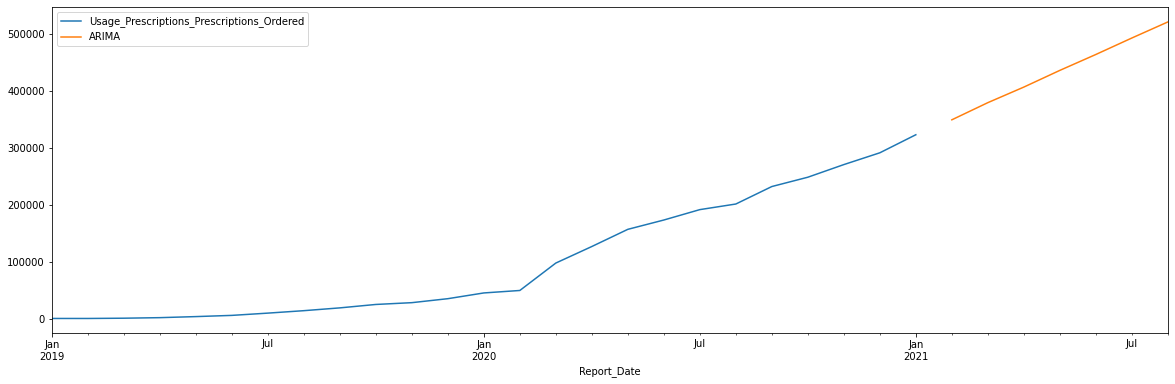

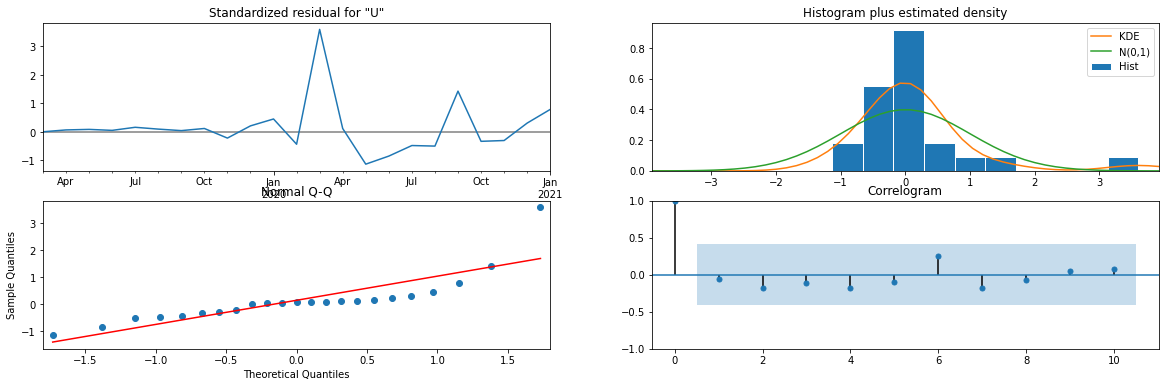

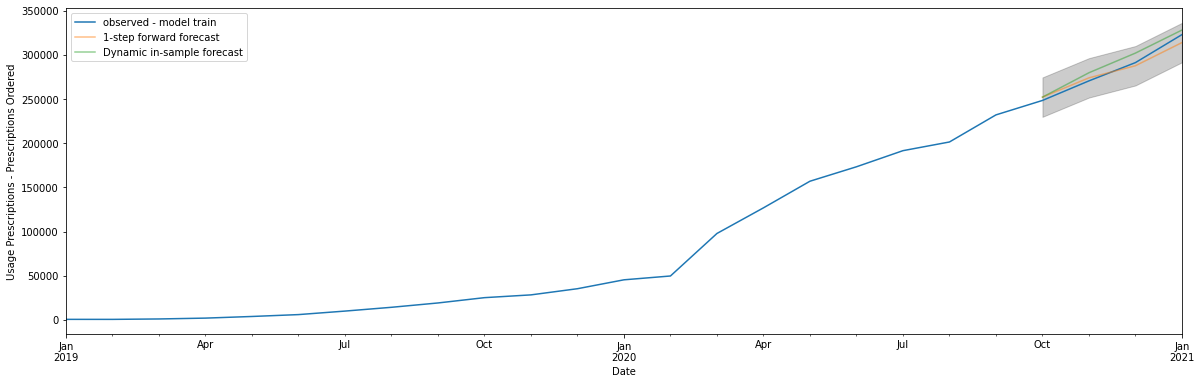

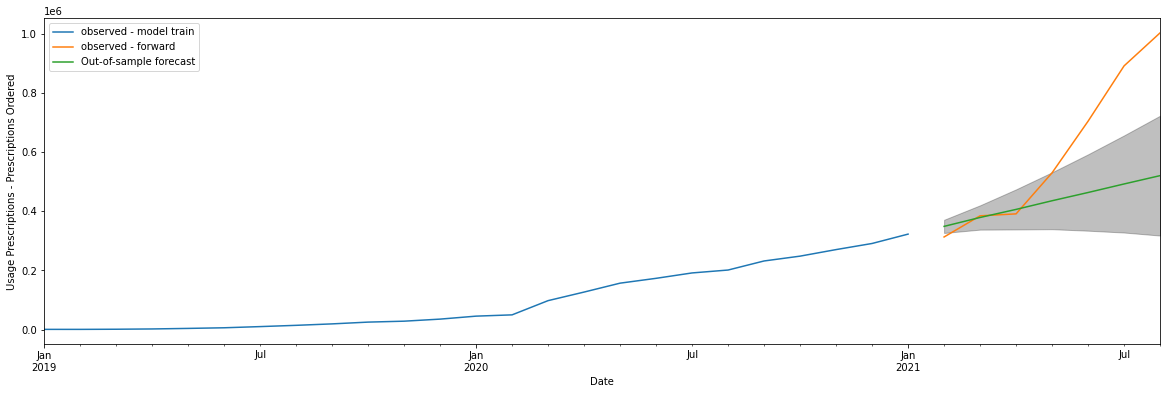

In [ ]:
## ARIMA
# fit model
data_presc_ori=data_n
data_presc = data_n.copy()
data_presc=data_presc[:'2021-09-30']

model = ARIMA(train, order=(1,2,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

plot_res_expl=False
if plot_res_expl:
  # line plot of residuals
  residuals = pd.DataFrame(model_fit.resid)
  residuals.plot()
  pyplot.show()
  # density plot of residuals
  residuals.plot(kind='kde')
  pyplot.show()
  # summary stats of residuals
  print(residuals.describe())

## Predictions
#y_hat = model_fit.predict(0,len(data_n)+5,dynamic=True)
#y_hat=model_fit.predict(len(data_presc),len(data_presc)+11,dynamic=False,typ='levels')
y_hat=model_fit.predict(start=start,end=end,dynamic=True,typ='levels')
y_hat = pd.Series(y_hat,name='ARIMA')
pd.concat([train,y_hat],axis=1).plot()
plt.legend()
plt.show()

# plotting diagnostics
model_fit.plot_diagnostics()
plt.show()
## One-step forward
# plotting prediction - appr 2
y_hat2 = model_fit.get_prediction(start=t_f_0,dynamic=False)
y_hat2_ci = y_hat2.conf_int()
y_hatdis = model_fit.get_prediction(start=t_f_0,dynamic=True) # dis - dynamic in sample
y_hatdis_ci = y_hatdis.conf_int()
ax = train.plot(label='observed - model train')
y_hat2.predicted_mean.plot(ax=ax,label='1-step forward forecast',alpha=0.5)
y_hatdis.predicted_mean.plot(ax=ax,label='Dynamic in-sample forecast',alpha=0.5)
#test.plot(label='observed - model test')
ax.fill_between(y_hat2_ci.index,
                y_hat2_ci.iloc[:,0],
                y_hat2_ci.iloc[:,1],
                color='k',
                alpha=0.2)
ax.set_xlabel('Date')
ax.set_ylabel('Usage Prescriptions - Prescriptions Ordered')
plt.legend()
plt.show()

## Plotting and visualising forecasts
y_hat2f = model_fit.get_forecast(steps=end-start+1)
y_hat2f_ci = y_hat2f.conf_int()

ax = train.plot(label='observed - model train')
test.plot(ax=ax,label='observed - forward')
y_hat2f.predicted_mean.plot(ax=ax,label='Out-of-sample forecast')
ax.fill_between(y_hat2f_ci.index,
                y_hat2f_ci.iloc[:,0],
                y_hat2f_ci.iloc[:,1],
                color='k',alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Usage Prescriptions - Prescriptions Ordered')
plt.legend()
plt.show()

The '1step forward' forecast works reasonably well in predicting what each immediate next single timepoint in the future may look like.
If we instead try to use past data (up to mid-2020) to predict multiple time-steps into the future ('dynamic forward forecast'), the model fares fairly well until May 2021, after which it starts heavily underestimating activity. This is around the time the certification surge came in, so it is expected that historic data would not be a good reflection of what was to come.

In [ ]:
y_hat2f.predicted_mean

2021-02-28    349114.241317
2021-03-31    379210.452733
2021-04-30    406523.096119
2021-05-31    435818.926164
2021-06-30    463701.810923
2021-07-31    492591.365615
Freq: M, Name: predicted_mean, dtype: float64

### Step: Separate into test and train (test points post-certification) - 'expected' to fare poorly as not accounting for 'external' behaviour / no exogenous variables

In [ ]:
train, test = data_presc[:'2021-05-31'], data_presc['2021-06-01':] # up to May (inclusive) in train. Note we allow for first 'surge' point to be included. See how model fares with that first surge, at an ARIMA(1,2,1) level
start=len(train)
end=len(train)+len(test)-1

                                           SARIMAX Results                                           
Dep. Variable:     Usage_Prescriptions_Prescriptions_Ordered   No. Observations:                   29
Model:                                        ARIMA(1, 2, 1)   Log Likelihood                -305.195
Date:                                       Mon, 08 Nov 2021   AIC                            616.390
Time:                                               13:47:31   BIC                            620.278
Sample:                                           01-31-2019   HQIC                           617.546
                                                - 05-31-2021                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000     

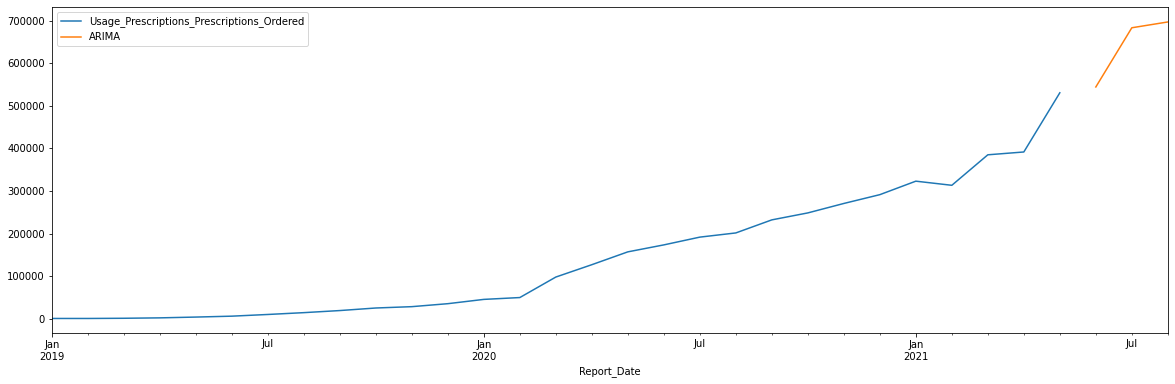

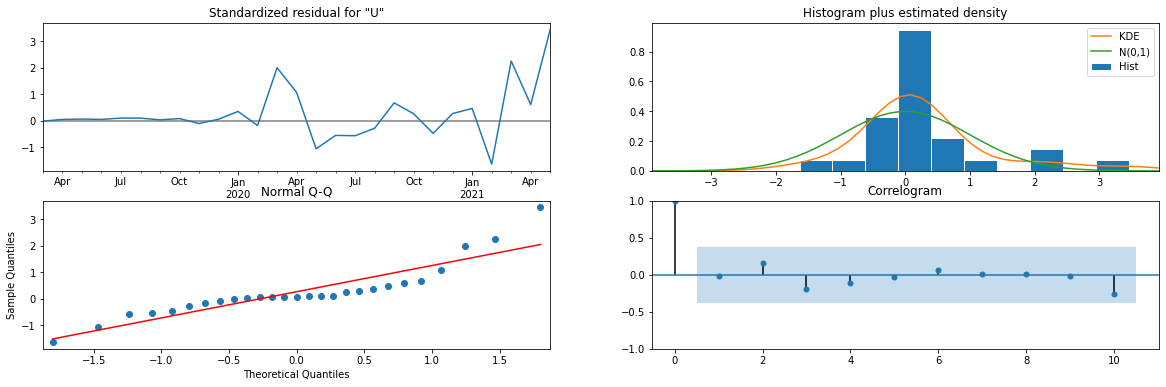

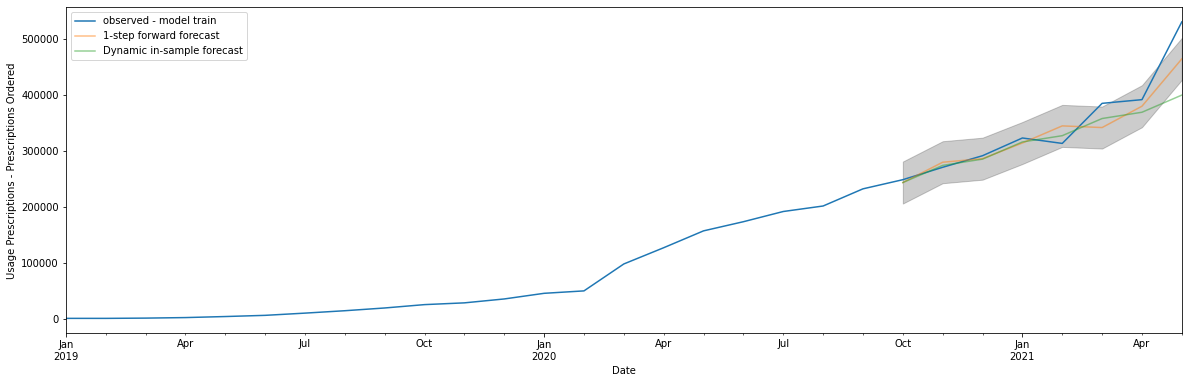

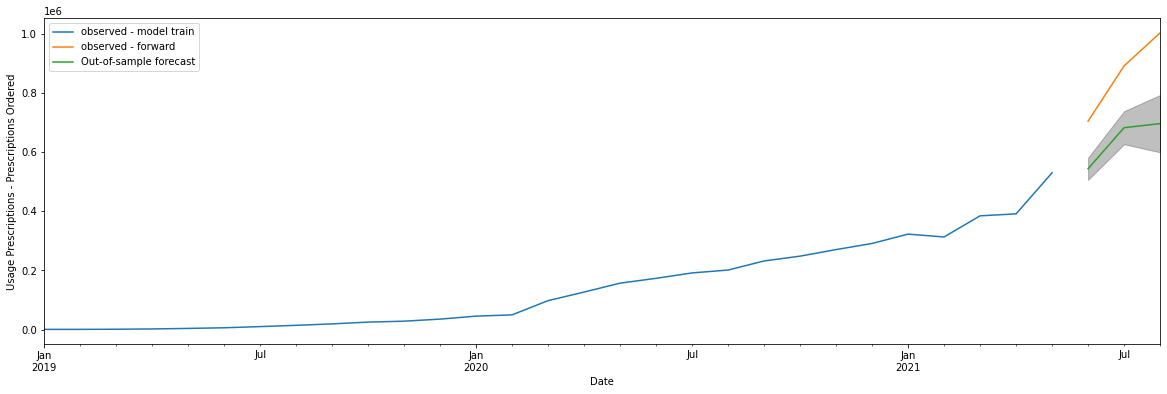

In [ ]:
## ARIMA
# fit model

model = ARIMA(train, order=(1,2,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

plot_res_expl=False
if plot_res_expl:
  # line plot of residuals
  residuals = pd.DataFrame(model_fit.resid)
  residuals.plot()
  pyplot.show()
  # density plot of residuals
  residuals.plot(kind='kde')
  pyplot.show()
  # summary stats of residuals
  print(residuals.describe())

## Predictions
#y_hat = model_fit.predict(0,len(data_n)+5,dynamic=True)
#y_hat=model_fit.predict(len(data_presc),len(data_presc)+11,dynamic=False,typ='levels')
y_hat=model_fit.predict(start=start,end=end,dynamic=True,typ='levels')
y_hat = pd.Series(y_hat,name='ARIMA')
pd.concat([train,y_hat],axis=1).plot()
plt.legend()
plt.show()

# plotting diagnostics
model_fit.plot_diagnostics()
plt.show()
## One-step forward
# plotting prediction - appr 2
y_hat2 = model_fit.get_prediction(start=t_f_0,dynamic=False)
y_hat2_ci = y_hat2.conf_int()
y_hatdis = model_fit.get_prediction(start=t_f_0,dynamic=True) # dis - dynamic in sample
y_hatdis_ci = y_hatdis.conf_int()
ax = train.plot(label='observed - model train')
y_hat2.predicted_mean.plot(ax=ax,label='1-step forward forecast',alpha=0.5)
y_hatdis.predicted_mean.plot(ax=ax,label='Dynamic in-sample forecast',alpha=0.5)
ax.fill_between(y_hat2_ci.index,
                y_hat2_ci.iloc[:,0],
                y_hat2_ci.iloc[:,1],
                color='k',
                alpha=0.2)
ax.set_xlabel('Date')
ax.set_ylabel('Usage Prescriptions - Prescriptions Ordered')
plt.legend()
plt.show()

## Plotting and visualising forecasts
y_hat2f = model_fit.get_forecast(steps=end-start+1)
y_hat2f_ci = y_hat2f.conf_int()

ax = train.plot(label='observed - model train')
test.plot(ax=ax,label='observed - forward')
y_hat2f.predicted_mean.plot(ax=ax,label='Out-of-sample forecast')
ax.fill_between(y_hat2f_ci.index,
                y_hat2f_ci.iloc[:,0],
                y_hat2f_ci.iloc[:,1],
                color='k',alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Usage Prescriptions - Prescriptions Ordered')
plt.legend()
plt.show()

The fit for the forecast is quite good, whether 1-step forward or dynamic. As expected though, if we use the model to predict post-certification timepoints, this is an underestimate (clear external factors the time-series itself would not be expected to capture).

This type of trendline can be useful though to add to the narrative on "How many transactions are being realised over-and-above what would be expected for these months, given the Certification surge.


In [ ]:
y_hat2f.predicted_mean

2021-06-30    544011.453421
2021-07-31    682975.965268
2021-08-31    696605.906840
Freq: M, Name: predicted_mean, dtype: float64

### Truly forecasting

                                           SARIMAX Results                                           
Dep. Variable:     Usage_Prescriptions_Prescriptions_Ordered   No. Observations:                   32
Model:                                        ARIMA(1, 2, 1)   Log Likelihood                -353.576
Date:                                       Mon, 08 Nov 2021   AIC                            713.151
Time:                                               14:08:35   BIC                            717.355
Sample:                                           01-31-2019   HQIC                           714.496
                                                - 08-31-2021                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9941     

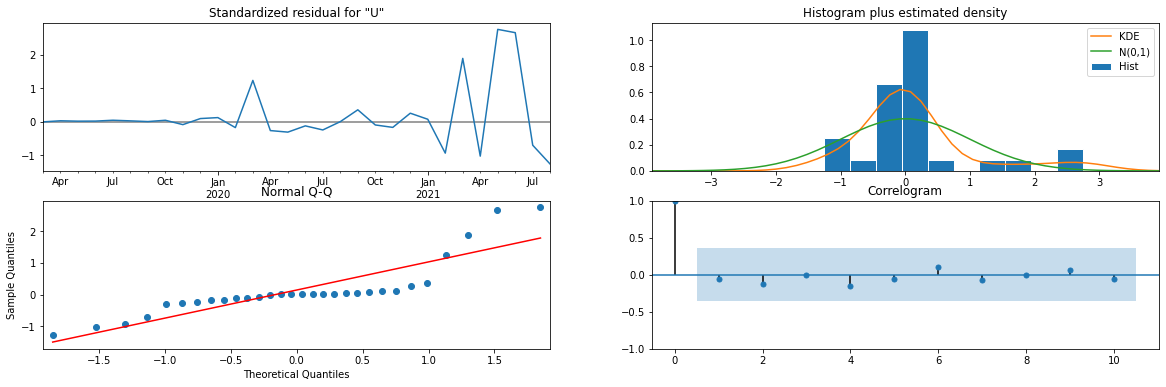

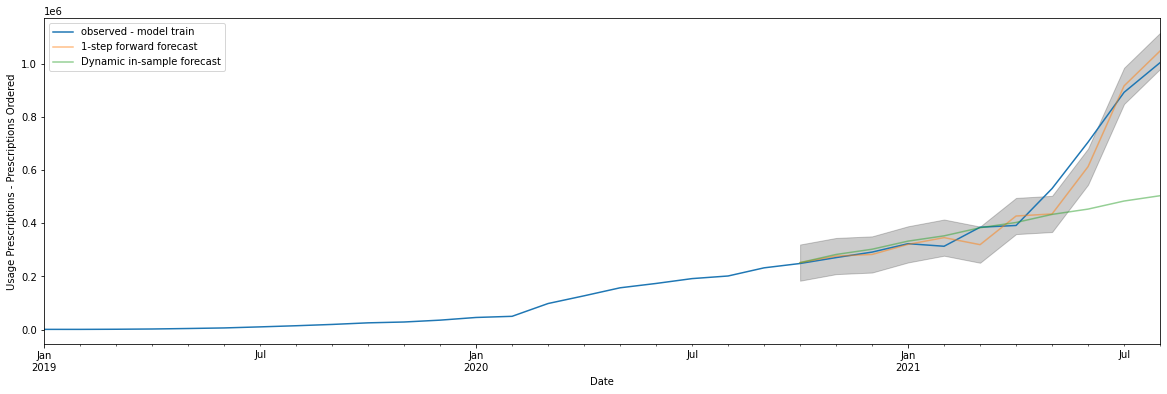

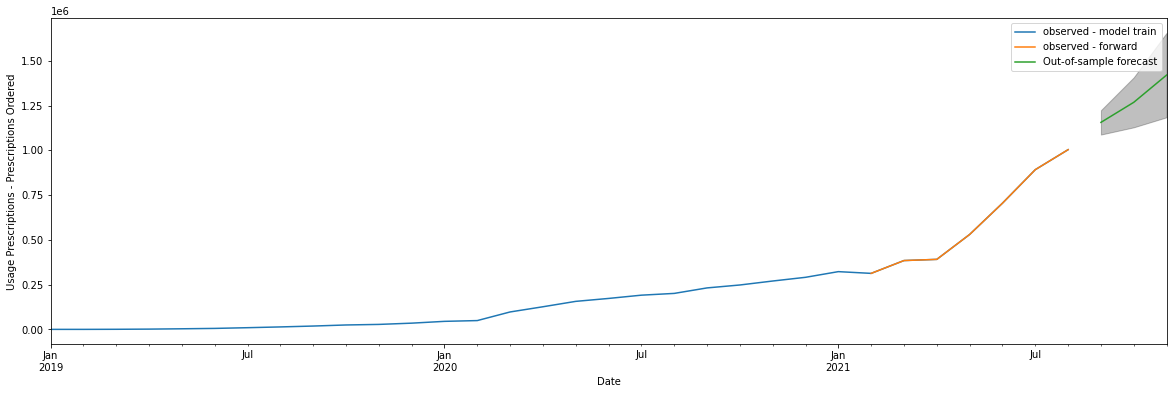

In [ ]:
## ARIMA
# fit model
train = data_presc

model = ARIMA(train, order=(1,2,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

# plotting diagnostics
model_fit.plot_diagnostics()
plt.show()
## One-step forward
# plotting prediction - appr 2
y_hat2 = model_fit.get_prediction(start=t_f_0,dynamic=False)
y_hat2_ci = y_hat2.conf_int()
y_hatdis = model_fit.get_prediction(start=t_f_0,dynamic=True) # dis - dynamic in sample
y_hatdis_ci = y_hatdis.conf_int()
ax = train.plot(label='observed - model train')
y_hat2.predicted_mean.plot(ax=ax,label='1-step forward forecast',alpha=0.5)
y_hatdis.predicted_mean.plot(ax=ax,label='Dynamic in-sample forecast',alpha=0.5)
ax.fill_between(y_hat2_ci.index,
                y_hat2_ci.iloc[:,0],
                y_hat2_ci.iloc[:,1],
                color='k',
                alpha=0.2)
ax.set_xlabel('Date')
ax.set_ylabel('Usage Prescriptions - Prescriptions Ordered')
plt.legend()
plt.show()

## Plotting and visualising forecasts (3 steps ahead)
y_hat2f = model_fit.get_forecast(steps=3)
y_hat2f_ci = y_hat2f.conf_int()

ax = train.plot(label='observed - model train')
test.plot(ax=ax,label='observed - forward')
y_hat2f.predicted_mean.plot(ax=ax,label='Out-of-sample forecast')
ax.fill_between(y_hat2f_ci.index,
                y_hat2f_ci.iloc[:,0],
                y_hat2f_ci.iloc[:,1],
                color='k',alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Usage Prescriptions - Prescriptions Ordered')
plt.legend()
plt.show()

## Simple Exponential Smoothing (SES)

In [ ]:
# SES example
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
# fit model
model = SimpleExpSmoothing(data_presc)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data_presc), len(data_presc))
print(yhat)

2021-09-30    956641.774545
Freq: M, dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


## Double Exponential Smoothing (DES) aka Holt Method

---



## Triple Exponential Smoothing (TES) aka Holt-Winters Method (HWES)

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# fit model
model = ExponentialSmoothing(data_presc)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data_presc), len(data_presc))
print(yhat)

2021-09-30    956641.774545
Freq: M, dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [ ]:
y_hat = model_fit.predict(len(data_n),len(data_n)+10,dynamic=True)